In [1]:
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras import layers
import cv2
import os
import numpy as np
import math
import sys
import os
from tensorflow.python.client import device_lib
import matplotlib.pyplot as plt
from plyfile import *
from mpl_toolkits.mplot3d import Axes3D
import open3d as o3d 
import numpy as np
import scipy.stats
import random
import pandas as pd
from sklearn.metrics import confusion_matrix

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
#点云文件导入
##############导入点云数据#################
pcd_AC13_1 = o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/AC13-1.ply")
pcd_AC13_2 = o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/AC13-2.ply")
pcd_AC16_3 = o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/AC16-3.ply")
pcd_AC16_4 = o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/AC16-4.ply")
pcd_UT5_1  = o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/UT5-1.ply")
pcd_UT5_2  = o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/UT5-2.ply")
pcd_UT5_3  = o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/UT5-3.ply")
pcd_UT5_4  = o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/UT5-4.ply")
pcd_SMA13_1= o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/SMA13-1.ply")
pcd_SMA13_2= o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/SMA13-2.ply")
pcd_OGFC10_1= o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/OGFC10-1.ply")
#############点云标准化####################
def standard_pointcloud(point_cloud):
    Point_standard=[]
    Point=np.asarray(point_cloud.points)    
    x=np.array(Point[:,0])[...,np.newaxis]
    y=np.array(Point[:,1])[...,np.newaxis]
    z=np.array(Point[:,2])[...,np.newaxis]
    Point_standard=np.concatenate((x-np.min(x),y-np.min(y),z-np.min(z)),axis=-1)
    return Point_standard
    
AC13_1=standard_pointcloud(pcd_AC13_1)
AC13_2=standard_pointcloud(pcd_AC13_2)
AC16_3=standard_pointcloud(pcd_AC16_3)
AC16_4=standard_pointcloud(pcd_AC16_4)
UT5_1=standard_pointcloud(pcd_UT5_1)
UT5_2=standard_pointcloud(pcd_UT5_2)
UT5_3=standard_pointcloud(pcd_UT5_3)
UT5_4=standard_pointcloud(pcd_UT5_4)
SMA13_1= standard_pointcloud(pcd_SMA13_1)
SMA13_2= standard_pointcloud(pcd_SMA13_2)
OGFC10_1 =  standard_pointcloud(pcd_OGFC10_1)

point_cloud_array_group = []
point_cloud_array_group.append(AC13_1)
point_cloud_array_group.append(AC13_2)
point_cloud_array_group.append(AC16_3)
point_cloud_array_group.append(AC16_4)
point_cloud_array_group.append(UT5_1)
point_cloud_array_group.append(UT5_2)
point_cloud_array_group.append(UT5_3)
point_cloud_array_group.append(UT5_4)
point_cloud_array_group.append(SMA13_1)
point_cloud_array_group.append(SMA13_2)
point_cloud_array_group.append(OGFC10_1)
#############点云标准化####################
def standard_pointcloud(point_cloud):
    Point_standard=[]  
    x=np.array(point_cloud[:,0])[...,np.newaxis]
    y=np.array(point_cloud[:,1])[...,np.newaxis]
    z=np.array(point_cloud[:,2])[...,np.newaxis]
    Point_standard=np.concatenate((x-np.min(x),y-np.min(y),z-np.min(z)),axis=-1)
    return Point_standard
######################按照计算的H_final进行窗口滑动切分#########################
H_final=51
AC13=[0,6,4,3.5,5.5,7.5,10.5,16,23.5,18.5,5,0]#级配
AC16=[0,5.4,2.4,2.4,3.7,4.1,7.8,5.5,26.3,20.1,16.6,5.7]#级配 
SMA13=[0,10.7,2.1,1.4,1.1,1.2,2.9,9.4,30.3,31.5,8.2,1.2]#级配
UT5=[0,6.7,2,2.5,5,20,13.4,48.8,1.5,0.1,0,0]#级配
OGFC10=[0,4,1.5,2,2,2.5,4,44,35,5,0,0]#级配
def split_slide(point_cloud_array_origion,H_new=H_final, intervial =[5,5]):
    L=int(np.max(point_cloud_array_origion[:,0]))
    W=int(np.max(point_cloud_array_origion[:,1]))
    Point_cloud_small = []
    L_intervial = intervial[0]
    W_intervial = intervial[1]
    for i in range (0,L-H_new,L_intervial):
        for j in range (0,W-H_new,W_intervial):
            temp_point_cloud = point_cloud_array_origion[np.where((point_cloud_array_origion[:,1]>i)&
                                                                  (point_cloud_array_origion[:,1]<(H_new+i))&
                                                                  (point_cloud_array_origion[:,0]>j)&
                                                                  (point_cloud_array_origion[:,0]<(H_new+j)))]
            temp_point_cloud = standard_pointcloud(temp_point_cloud)
            Point_cloud_small.append(temp_point_cloud)
    return Point_cloud_small
########################点云转RCBD图像############
def PointCloud_to_RGBD(pointCloud_array):
    pcd=o3d.geometry.PointCloud()
    pcd.points=o3d.utility.Vector3dVector(pointCloud_array)
    vis = o3d.visualization.Visualizer()
    vis.create_window()
    vis.get_render_option().point_color_option = o3d.visualization.PointColorOption.Color
    vis.get_render_option().point_size = 3.0
    vis.add_geometry(pcd)
    Image=vis.capture_screen_float_buffer(do_render=True)
    vis.destroy_window()
    Image_array = np.array(Image)[150:900,580:1320]
    return Image_array
############开始制作数据###################
PointCloud_new =[]
#制作Ground truth
Y_Data=np.zeros((1,12))
for i in range(11):
    temp=split_slide(point_cloud_array_group[i])
    #print(len(temp))
    PointCloud_new=np.concatenate((PointCloud_new,temp),axis=0)
    if (i==0) or (i==1):
        temp2 = np.full((len(temp),12),AC13)
    elif (i==2) or (i==3):
        temp2 = np.full((len(temp),12),AC16)
    elif (i==4) or (i==5) or (i==6) or (i==7):
        temp2 = np.full((len(temp),12),UT5)
    elif (i==8) or (i==9):
        temp2 = np.full((len(temp),12),SMA13)
    elif (i==10):
        temp2 = np.full((len(temp),12),OGFC10) 
    #print(temp2.shape)
    Y_Data = np.concatenate((Y_Data,temp2),axis=0)
Y_Data = np.delete(Y_Data, 1, 0)#把第一行0删掉
print(Y_Data.shape)
Image_set=[]
for i in range(len(PointCloud_new )):
    temp = PointCloud_to_RGBD(PointCloud_new[i])
    Image_set.append(temp)
Image_set=np.array(Image_set)
print(Image_set.shape)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


(1579, 12)
(1579, 750, 740, 3)


In [3]:
#### 数据集1397分，切分为1200训练 197测试#######################
arr = np.array(range(0, 1579, 1))
r = np.random.permutation(arr)
Train_X_Data = []
Train_Y_Data = []
for i in range(1379):
    Train_X_Data.append(Image_set[r[i]])
    Train_Y_Data.append(Y_Data[r[i]])

Test_X_Data = []
Test_Y_Data = []
for i in range(1379,1579):
    Test_X_Data.append(Image_set[r[i]])
    Test_Y_Data.append(Y_Data[r[i]])
    
Train_X_Data = np.array(Train_X_Data)
Train_Y_Data = np.array(Train_Y_Data)
Test_X_Data = np.array(Test_X_Data)
Test_Y_Data = np.array(Test_Y_Data)

print(Train_X_Data.shape)
print(Train_Y_Data.shape)
print(Test_X_Data.shape)
print(Test_Y_Data.shape)

(1379, 750, 740, 3)
(1379, 12)
(200, 750, 740, 3)
(200, 12)


In [4]:
class VGG(tf.keras.Model):
    def __init__(self,num_classes):
        super(VGG, self).__init__()

        self.conv1_1 = layers.Conv2D(64,3,padding='same',activation="relu")
        self.conv1_2 = layers.Conv2D(64,3,padding='same',activation="relu")
        self.max_pool_1 = layers.MaxPool2D(2,strides=2)
        self.BN1 = layers.BatchNormalization()

        self.conv2_1 = layers.Conv2D(128,3,padding='same',activation="relu") 
        self.conv2_2 = layers.Conv2D(128,3,padding='same',activation="relu")
        self.max_pool_2 = layers.MaxPool2D(2)
        self.BN2 = layers.BatchNormalization()

        self.conv3_1 = layers.Conv2D(256,3,padding='same',activation="relu")    
        self.conv3_2 = layers.Conv2D(256,3,padding='same',activation="relu")
        self.conv3_3 = layers.Conv2D(256,3,padding='same',activation="relu")
        self.max_pool_3 = layers.MaxPool2D(2,strides=2)
        self.BN3 = layers.BatchNormalization()

        self.conv4_1 = layers.Conv2D(512,3,padding='same',activation="relu")
        self.conv4_2 = layers.Conv2D(512,3,padding='same',activation="relu")
        self.conv4_3 = layers.Conv2D(512,3,padding='same',activation="relu")
        self.max_pool_4 = layers.MaxPool2D(2,strides=2)
        self.BN4 = layers.BatchNormalization()

        self.conv5_1 = layers.Conv2D(512,3,padding='same',activation="relu")    
        self.conv5_2 = layers.Conv2D(512,3,padding='same',activation="relu")
        self.conv5_3 = layers.Conv2D(512,3,padding='same',activation="relu")
        self.max_pool_5 = layers.MaxPool2D(2,strides=2)
        self.BN5 = layers.BatchNormalization()

        self.flatten = layers.Flatten()
        self.fully_connected_1 = layers.Dense(512,activation="relu")
        self.fully_connected_2 = layers.Dense(512,activation="relu")
        self.classification = layers.Dense(num_classes,activation='relu')
        
    def call(self,x):
        x = self.conv1_1(x)
        x = self.conv1_2(x)
        x = self.max_pool_1(x)
        x = self.BN1(x)

        x = self.conv2_1(x)
        x = self.conv2_2(x)
        x = self.max_pool_2(x)
        x = self.BN2(x)

        x = self.conv3_1(x)
        x = self.conv3_2(x)
        x = self.conv3_3(x)
        x = self.max_pool_3(x)
        x = self.BN3(x)

        x = self.conv4_1(x)
        x = self.conv4_2(x)
        x = self.conv4_3(x)
        x = self.max_pool_4(x)
        x = self.BN4(x)

        x = self.conv5_1(x)
        x = self.conv5_2(x)
        x = self.conv5_3(x)
        x = self.max_pool_5(x)
        x = self.BN5(x)

        x = self.flatten(x)
        x = self.fully_connected_1(x)
        x = self.fully_connected_2(x)
        x = self.classification(x)
        
        return x

In [5]:
model = VGG(num_classes=12)
model.build(input_shape=(None,750, 740, 3))
model.summary()
Batch_size=8
lr=1e-3
model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss=tf.keras.losses.MAE)
Callback = tf.keras.callbacks.ModelCheckpoint("VGG16.h5", 
                                           monitor='val_loss', 
                                           save_best_only=True, 
                                           save_weights_only=True)
Model_history=model.fit(x=Train_X_Data,y=Train_Y_Data,batch_size=Batch_size,epochs =200, validation_split=0.2, callbacks=Callback)

Model: "vgg"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  1792      
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
batch_normalization (BatchNo multiple                  256       
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  73856     
_________________________________________________________________
conv2d_3 (Conv2D)            multiple                  147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0       

138/138 [==============================] - 56s 404ms/step - loss: 1.0729 - val_loss: 2.5121
Epoch 42/200
138/138 [==============================] - 56s 405ms/step - loss: 1.0557 - val_loss: 2.1807
Epoch 43/200
138/138 [==============================] - 56s 404ms/step - loss: 1.0451 - val_loss: 1.9766
Epoch 44/200
138/138 [==============================] - 56s 405ms/step - loss: 1.0504 - val_loss: 2.0631
Epoch 45/200
138/138 [==============================] - 56s 405ms/step - loss: 1.0437 - val_loss: 1.9855
Epoch 46/200
138/138 [==============================] - 56s 405ms/step - loss: 1.0195 - val_loss: 2.5292
Epoch 47/200
138/138 [==============================] - 55s 401ms/step - loss: 1.0261 - val_loss: 7.5788
Epoch 48/200
138/138 [==============================] - 54s 395ms/step - loss: 1.0725 - val_loss: 4.4903
Epoch 49/200
138/138 [==============================] - 54s 395ms/step - loss: 1.0155 - val_loss: 3.6518
Epoch 50/200
138/138 [==============================] - 54s 395ms/st

Epoch 119/200
138/138 [==============================] - 55s 397ms/step - loss: 0.6959 - val_loss: 4.4590
Epoch 120/200
138/138 [==============================] - 55s 397ms/step - loss: 0.6720 - val_loss: 1.6278
Epoch 121/200
138/138 [==============================] - 55s 396ms/step - loss: 0.6669 - val_loss: 1.7526
Epoch 122/200
138/138 [==============================] - 55s 396ms/step - loss: 0.6275 - val_loss: 2.4403
Epoch 123/200
138/138 [==============================] - 55s 396ms/step - loss: 0.6130 - val_loss: 2.2527
Epoch 124/200
138/138 [==============================] - 55s 397ms/step - loss: 0.6638 - val_loss: 1.7740
Epoch 125/200
138/138 [==============================] - 55s 396ms/step - loss: 0.6272 - val_loss: 2.4851
Epoch 126/200
138/138 [==============================] - 55s 397ms/step - loss: 0.6147 - val_loss: 3.6061
Epoch 127/200
138/138 [==============================] - 55s 396ms/step - loss: 0.6640 - val_loss: 1.5188
Epoch 128/200
138/138 [=======================

138/138 [==============================] - 55s 396ms/step - loss: 0.6467 - val_loss: 3.0188
Epoch 197/200
138/138 [==============================] - 55s 396ms/step - loss: 0.6038 - val_loss: 2.0472
Epoch 198/200
138/138 [==============================] - 55s 396ms/step - loss: 0.6124 - val_loss: 2.5016
Epoch 199/200
138/138 [==============================] - 55s 396ms/step - loss: 0.5930 - val_loss: 2.4719
Epoch 200/200
138/138 [==============================] - 55s 396ms/step - loss: 0.5956 - val_loss: 1.7329


In [6]:
Save_history = Model_history.history
Save_history = pd.DataFrame(Save_history)
writer = pd.ExcelWriter('C:/Users/Administrator/Desktop/surface/实验结果存放/VGG16_conv2D_loss.xlsx')  #关键2，创建名称为hhh的excel表格
Save_history.to_excel(writer,'page_1',float_format='%.5f')  #关键3，float_format 控制精度，将data_df写到hhh表格的第一页中。若多个文件，可以在page_2中写入
writer.save() 

7/7 [==============================] - 10s 311ms/step - loss: 1.5543


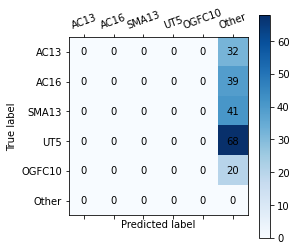

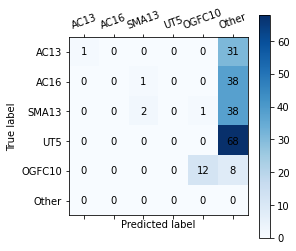

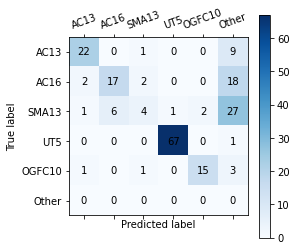

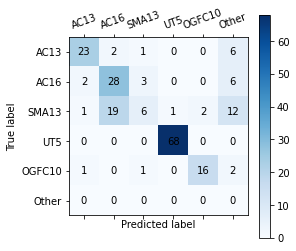

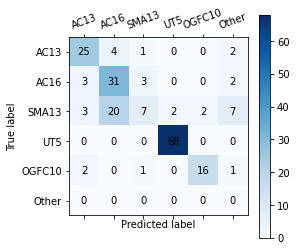

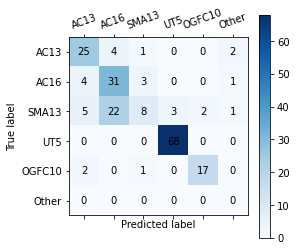

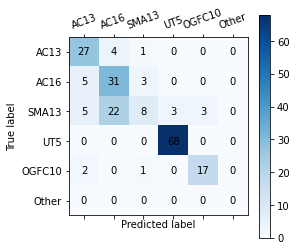

In [7]:
############Test性能测试###################
def identification(predicted_gradient,real_gradient,threshold):
    AC13=[0,6,4,3.5,5.5,7.5,10.5,16,23.5,18.5,5,0]#级配
    AC16=[0,5.4,2.4,2.4,3.7,4.1,7.8,5.5,26.3,20.1,16.6,5.7]#级配 
    SMA13=[0,10.7,2.1,1.4,1.1,1.2,2.9,9.4,30.3,31.5,8.2,1.2]#级配
    UT5=[0,6.7,2,2.5,5,20,13.4,48.8,1.5,0.1,0,0]#级配
    OGFC10=[0,4,1.5,2,2,2.5,4,44,35,5,0,0]#级配
    if np.average(np.abs(real_gradient-AC13))==0:
        Real_result=0
    elif np.average(np.abs(real_gradient-AC16))==0:
        Real_result=1
    elif np.average(np.abs(real_gradient-SMA13))==0:
        Real_result=2
    elif np.average(np.abs(real_gradient-UT5))==0:
        Real_result=3
    elif np.average(np.abs(real_gradient-OGFC10))==0:
        Real_result=4
        
    R_AC13=np.average(np.abs(predicted_gradient-AC13))
    R_AC16=np.average(np.abs(predicted_gradient-AC16))
    R_SMA13=np.average(np.abs(predicted_gradient-SMA13))
    R_UT5=np.average(np.abs(predicted_gradient-UT5))
    R_OGFC10=np.average(np.abs(predicted_gradient-OGFC10))
    
    Predicted_result =np.argmin(np.array([R_AC13,R_AC16,R_SMA13,R_UT5,R_OGFC10]))
    
    if np.min(np.array([R_AC13,R_AC16,R_SMA13,R_UT5,R_OGFC10]))>threshold:
        Predicted_result = 5
    
    return Real_result, Predicted_result

n_classes = 12
Batch_size=4
model = VGG(num_classes=12)
model.build(input_shape=(None, 750, 740, 3))
model.load_weights("VGG16.h5")
model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss=tf.keras.losses.MAE)
model.evaluate(Test_X_Data,Test_Y_Data)
Thr_list = [0.1,0.5,1,1.5,2,2.5,3]
for Thr in Thr_list:
    Real_result = []
    Predicted_result = []
    for i in range(len(Test_X_Data)):
        R,P=identification(model(np.array(Test_X_Data[i])[np.newaxis,...])[0],Test_Y_Data[i],Thr)
        Real_result.append(R)
        Predicted_result.append(P)
    #######绘制混淆矩阵################
    C = confusion_matrix(Real_result, Predicted_result,labels=[0,1,2,3,4,5]) 
    plt.matshow(C, cmap=plt.cm.Blues) # 根据最下面的图按自己需求更改颜色
    plt.colorbar()
    for i in range(len(C)):
        for j in range(len(C)):
            plt.annotate(C[j, i], xy=(i, j), horizontalalignment='center', verticalalignment='center')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks(range(0,6), labels=['AC13','AC16','SMA13','UT5','OGFC10','Other'], rotation=20) # 将x轴或y轴坐标，刻度 替换为文字/字符
    plt.yticks(range(0,6), labels=['AC13','AC16','SMA13','UT5','OGFC10','Other'])
    plt.savefig('C:/Users/Administrator/Desktop/surface/实验结果存放/VGG16_conv2D'+str(Thr)+'.png',dpi=600)#保存图片
    plt.show()